In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

###
 https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction

In [3]:
telcom = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
#first few rows
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

# 데이터 전처리
- 범주형 , 명목형, 2진 , 멀티 
- 숫자는 standardScaler
- 2가지 -> labelEncoder()
- 3개이상 -> pd.get_dummies
- 숫자는 standardScaler()
- 

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]
# 2진 컬럼 레이블 인코딩
#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

In [13]:
bin_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'Churn']

# Correlation Matrix

In [14]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

# Visualising data with principal components
## 주성분 
- https://ratsgo.github.io/machine%20learning/2017/04/24/PCA/
- https://darkpgmr.tistory.com/110

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Starter Guide : Preprocessing & RandomForest

In [16]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [17]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [18]:
data.drop(['customerID'], axis=1, inplace=True)

In [19]:
data['Churn'].value_counts(sort = False)

No     5174
Yes    1869
Name: Churn, dtype: int64

## data Wrangling

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


### Preprocessing

In [21]:
data['gender'].head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: gender, dtype: object

### data['Churn'] 데이터들 yes면 1 no면 0

In [24]:
data['Churn'] = data['Churn'].map(lambda s :1  if s =='Yes' else 0)

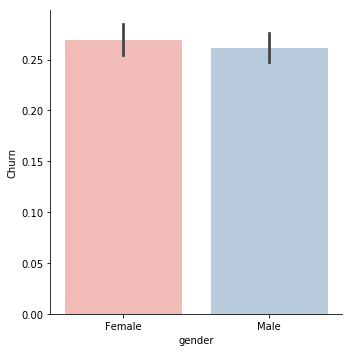

In [25]:
g = sns.factorplot(y="Churn",x="gender",data=data,kind="bar" ,palette = "Pastel1")

In [26]:
data['SeniorCitizen'].value_counts()
# 노인이면 1 아니면 0 

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [27]:
data['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [28]:
# 파트너 yes or no 르르 숫자로
data['Partner'] = data['Partner'].map(lambda s :1  if s =='Yes' else 0)
data['Partner'].value_counts()

0    3641
1    3402
Name: Partner, dtype: int64

In [29]:
data['Dependents'] = data['Dependents'].map(lambda s :1  if s =='Yes' else 0)
data['PhoneService'] = data['PhoneService'].map(lambda s :1  if s =='Yes' else 0)
data['PaperlessBilling'] = data['PaperlessBilling'].map(lambda s :1  if s =='Yes' else 0)

In [30]:
data['tenure'].head()

0     1
1    34
2     2
3    45
4     2
Name: tenure, dtype: int64

## 이탈안한사람 빨간색 0
## 이탈한사람 파란색 1
## 기간 분포를 churn숫자로 분포 알아보자

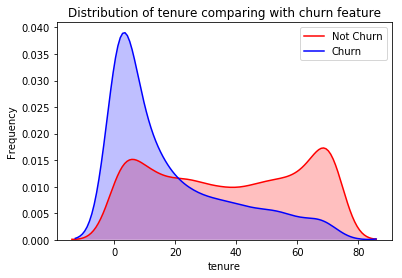

In [31]:
# tenure distibution 
g = sns.kdeplot(data.tenure[(data["Churn"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(data.tenure[(data["Churn"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("tenure")
g.set_ylabel("Frequency")
plt.title('Distribution of tenure comparing with churn feature')
g = g.legend(["Not Churn","Churn"])

### 20개월 이하 사람들은 이탈한것으로 보임
### 높은 기간인사람은 낮은 이탈율을 보임

In [32]:
data['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

## No phone service 없애자 
    

In [34]:
data['MultipleLines'].replace('No phone service','No',inplace=True) #없애고 0또는 1로
data['MultipleLines'] = data['MultipleLines'].map(lambda s:1 if s=='Yes' else 0)
data['MultipleLines'].value_counts() #확인

0    4072
1    2971
Name: MultipleLines, dtype: int64

In [35]:
data['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [36]:
data['Has_InternetService'] = data['InternetService'].map(lambda s :0  if s =='No' else 1)
data['Fiber_optic'] = data['InternetService'].map(lambda s :1  if s =='Fiber optic' else 0)
data['DSL'] = data['InternetService'].map(lambda s :1  if s =='DSL' else 0)

In [37]:
print(data['Has_InternetService'].value_counts())
print(data['Fiber_optic'].value_counts())
print(data['DSL'].value_counts())
data.drop(['InternetService'], axis=1, inplace=True)

1    5517
0    1526
Name: Has_InternetService, dtype: int64
0    3947
1    3096
Name: Fiber_optic, dtype: int64
0    4622
1    2421
Name: DSL, dtype: int64


In [38]:
data['OnlineSecurity'] = data['OnlineSecurity'].map(lambda s :1  if s =='Yes' else 0)
data['OnlineBackup'] = data['OnlineBackup'].map(lambda s :1  if s =='Yes' else 0)
data['DeviceProtection'] = data['DeviceProtection'].map(lambda s :1  if s =='Yes' else 0)
data['TechSupport'] = data['TechSupport'].map(lambda s :1  if s =='Yes' else 0)
data['StreamingTV'] = data['StreamingTV'].map(lambda s :1  if s =='Yes' else 0)
data['StreamingMovies'] = data['StreamingMovies'].map(lambda s :1  if s =='Yes' else 0)

In [39]:
data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [40]:
data = pd.get_dummies(data=data, columns=['PaymentMethod'])

In [41]:
data[['PaymentMethod_Electronic check',
      'PaymentMethod_Mailed check',
      'PaymentMethod_Bank transfer (automatic)',
      'PaymentMethod_Credit card (automatic)']].head()

,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,0,1,0
4,1,0,0,0


In [42]:
data['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [43]:
data = pd.get_dummies(data=data, columns=['Contract'])

In [44]:
data['MonthlyCharges'].head()

0    29.85
1    56.95
2    53.85
3    42.30
4    70.70
Name: MonthlyCharges, dtype: float64

In [45]:
data['TotalCharges'].head()
#어떻게 오브젝트 타입인지 알았지.. 

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object

In [46]:
## because 11 rows contain " " , it means 11 missing data in our dataset
len(data[data['TotalCharges'] == " "])
# 공백인게 있네 11개 

11

# 공백문자 지우는 !!!!!!!!!!!!!!!!!!!!!
# 타입변경은 to_numeric

In [47]:
data = data[data['TotalCharges'] != " "]

In [48]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

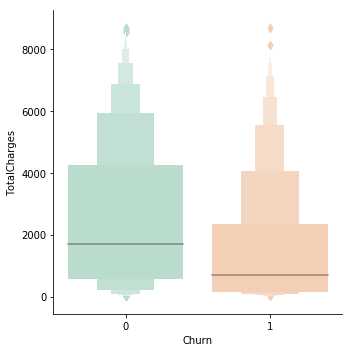

In [49]:
g = sns.factorplot(y="TotalCharges",x="Churn",data=data,kind="boxen", palette = "Pastel2")

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 27 columns):
gender                                     7032 non-null object
SeniorCitizen                              7032 non-null int64
Partner                                    7032 non-null int64
Dependents                                 7032 non-null int64
tenure                                     7032 non-null int64
PhoneService                               7032 non-null int64
MultipleLines                              7032 non-null int64
OnlineSecurity                             7032 non-null int64
OnlineBackup                               7032 non-null int64
DeviceProtection                           7032 non-null int64
TechSupport                                7032 non-null int64
StreamingTV                                7032 non-null int64
StreamingMovies                            7032 non-null int64
PaperlessBilling                           7032 non-null int64
MonthlyCha

In [51]:
## gender 뺴먹었네 ~
data = pd.get_dummies(data=data, columns=['gender'])

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 28 columns):
SeniorCitizen                              7032 non-null int64
Partner                                    7032 non-null int64
Dependents                                 7032 non-null int64
tenure                                     7032 non-null int64
PhoneService                               7032 non-null int64
MultipleLines                              7032 non-null int64
OnlineSecurity                             7032 non-null int64
OnlineBackup                               7032 non-null int64
DeviceProtection                           7032 non-null int64
TechSupport                                7032 non-null int64
StreamingTV                                7032 non-null int64
StreamingMovies                            7032 non-null int64
PaperlessBilling                           7032 non-null int64
MonthlyCharges                             7032 non-null float64
TotalChar

# gridsearch 를 사용하여 랜덤포레스트 할것이다
-랜덤 포레스트는 여러 개의 결정트리(Decision Tree)를 활용한 배깅 방식의 대표적인 알고리즘
 ## 장점
 - 결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있음
- 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있음
- 다양한 분야에서 좋은 성능을 나타냄


In [54]:
# 분리하기 
data["Churn"] = data["Churn"].astype(int)

Y_train = data["Churn"]
X_train = data.drop(labels = ["Churn"],axis = 1)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  cross_val_score,GridSearchCV

Rfclf = RandomForestClassifier(random_state=15)
Rfclf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

### 교차검증 반복
- cross_val_score( model , X, y, scoring = None, cv = None)
- model : 모형
- 독립변수 , 종속변수
- scoring : 성능 검증에 사용할 함수 이름
- cv : 교차 검증 생성기 객체 또는 숫자.    

In [56]:
# 10 Folds Cross Validation 
clf_score = cross_val_score(Rfclf, X_train, Y_train, cv=10)
print(clf_score)
clf_score.mean()
# 아무것도 안한 RF는 78 % 정확도 가지고있다. 

[0.79261364 0.78125    0.79119318 0.79374111 0.77667141 0.74822191
 0.77809388 0.77809388 0.79374111 0.79202279]


0.7825642910346857

## 튜닝하자 ~
- n_estimators : 결정트리의 갯수를 지정  디폴트는 10
- max_depth : 트리의 최대 깊이 원래 default
- max_features :  최적의 분할을 위해 고려할 최대 피쳐 개수 
### param_grid 딕트 형식으로 저장
### GridSearchCV( 모델, 파라미터 그리드)
## fit 해준다. 

#### gridSearchCv 객체의 best_params_ 가 최적의 값을 저장하고있음
### best_params_ 는 딕셔너리 형태로 값들 저장하고있다. 

In [57]:
%%time
param_grid  = { 
                'n_estimators' : [500,1200],
               # 'min_samples_split': [2,5,10,15,100],
               # 'min_samples_leaf': [1,2,5,10],
                'max_depth': range(1,5,2),
                'max_features' : ('log2', 'sqrt'),
                'class_weight':[{1: w} for w in [1,1.5]]
              }
GridRF = GridSearchCV(RandomForestClassifier(random_state=15), param_grid)
GridRF.fit(X_train,Y_train)

print( " 최상의 파라미터 알려주세요 :"+str(GridRF.best_params_))

 최상의 파라미터 알려주세요 :{'class_weight': {1: 1.5}, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 500}
Wall time: 1min 32s


### 대망의 그 값을 적용한 랜덤포레스트 분류기 만들기
# **GridRF.best_params_ 딕셔너리 형태로 
###{ '키워드' : '특정값 ' } 형태로 함수 내부로 전달된다. 

In [58]:
rf = RandomForestClassifier(random_state = 15, **GridRF.best_params_)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 1.5},
            criterion='gini', max_depth=3, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=15,
            verbose=0, warm_start=False)

# k-Fold CV k폴드 CV 정확도 매트릭스 


In [59]:
clf_score = cross_val_score(rf, X_train, Y_train, cv=10)
print(clf_score)
clf_score.mean()

[0.79829545 0.81534091 0.80965909 0.81507824 0.78236131 0.79374111
 0.81223329 0.79374111 0.78947368 0.7962963 ]


0.8006220484838906

### 2퍼센트 증가


In [61]:
rf.feature_importances_

array([8.07728484e-03, 6.11899120e-03, 8.55756828e-03, 1.57606336e-01,
       7.61444399e-04, 2.27299475e-03, 2.17537209e-02, 3.12022898e-03,
       1.13933366e-03, 1.46837428e-02, 4.11576795e-03, 3.04552115e-03,
       2.30241604e-02, 6.35295507e-02, 6.31745087e-02, 6.00853737e-02,
       9.59113197e-02, 1.32921413e-02, 1.61559552e-03, 3.17320307e-03,
       8.39636266e-02, 2.70988470e-03, 2.19452470e-01, 3.42020884e-02,
       1.04447575e-01, 6.79099257e-05, 9.76571739e-05])

# feature_importances_ 의 변수에 피쳐마다의 값들이 저장되있다.

In [60]:
Rfclf_fea = pd.DataFrame(rf.feature_importances_)
Rfclf_fea["Feature"] = list(X_train) 
Rfclf_fea.sort_values(by=0, ascending=False).head()

,0,Feature
22,0.219452,Contract_Month-to-month
3,0.157606,tenure
24,0.104448,Contract_Two year
16,0.095911,Fiber_optic
20,0.083964,PaymentMethod_Electronic check


# 제일 높은 5개 특성들만 시각화

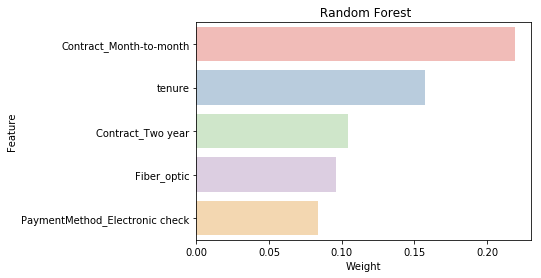

In [63]:
g = sns.barplot(0, "Feature", data = Rfclf_fea.sort_values(by=0, ascending=False)[0:5], 
               palette = "Pastel1", orient = "h")
g.set_xlabel("Weight")
g= g.set_title(" Random Forest")

In [64]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_train)

print(confusion_matrix(Y_train, y_pred))

[[4617  546]
 [ 836 1033]]
